In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! pip install shap
! pip install lime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=05b7aedeee2213ef20594d1a46746d3ab840fae98d05d3293b1eac39de8fa433
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Data Preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer # for missing values

# Loading the datasets
train_df = pd.read_csv('/content/KDDTrain+.csv', header=None)
test_df = pd.read_csv('/content/KDDTest+.csv', header=None)

# Columns meaning

# connection_length: Duration of the connection in seconds.
# protocol_type: Type of protocol (e.g., TCP, UDP, ICMP).
# service: Network service accessed during the connection (e.g., HTTP, FTP).
# flag: Connection status (e.g., SF for successful connection, REJ for rejected).
# source_bytes: Bytes sent from the source to the destination.
# destination_bytes: Bytes sent from the destination to the source.
# land: Binary flag indicating if the source and destination IP/port are the same.
# wrong_fragment: Number of wrong fragments in the connection.
# urgent_packets: Number of urgent packets in the connection.
# hot: Number of "hot" indicators, such as sensitive data accesses.
# num_failed_logins: Number of failed login attempts.
# login_success: Binary indicator for successful login.
# num_compromised: Number of compromised conditions during the connection.
# root_shell: Binary flag indicating if root access was obtained.
# su_attempted: Binary flag indicating if a superuser (su) command was attempted.
# num_root: Number of root accesses during the connection.
# num_file_creations: Number of file creation operations.
# num_shells: Number of shell prompts opened.
# num_access_files: Number of operations to access system files.
# num_outbound_cmds: Number of outbound commands in an FTP session (always 0).
# is_host_login: Binary flag indicating if the login is to the host itself.
# is_guest_login: Binary flag indicating if the login is from a guest account.
# count: Number of connections to the same host in the past two seconds.
# service_count: Number of connections to the same service in the past two seconds.
# serror_rate: Percentage of connections with SYN errors (connection establishment failure).
# service_serror_rate: Percentage of connections to the same service with SYN errors.
# rerror_rate: Percentage of connections with REJ errors (connection rejected).
# service_rerror_rate: Percentage of connections to the same service with REJ errors.
# same_service_rate: Percentage of connections to the same service.
# diff_service_rate: Percentage of connections to different services.
# service_diff_host_rate: Percentage of connections to the same service but different hosts.
# destination_host_count: Number of connections to the same destination host in the past two seconds.
# destination_host_service_count: Number of connections to the same service on the destination host.
# destination_host_same_service_rate: Percentage of connections to the same service on the destination host.
# destination_host_diff_service_rate: Percentage of connections to different services on the destination host.
# destination_host_same_source_port_rate: Percentage of connections to the same host and source port.
# destination_host_service_diff_host_rate: Percentage of connections to the same service but different hosts.
# destination_host_serror_rate: Percentage of connections to the destination host with SYN errors.
# destination_host_service_serror_rate: Percentage of connections to the same service on the destination host with SYN errors.
# destination_host_rerror_rate: Percentage of connections to the destination host with REJ errors.
# destination_host_service_rerror_rate: Percentage of connections to the same service on the destination host with REJ errors.
# label: Attack type

column_names = [
    "connection_length", "protocol_type", "service", "flag", "source_bytes",
    "destination_bytes", "land", "wrong_fragment", "urgent_packets", "hot", "num_failed_logins",
    "login_success", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "service_count", "serror_rate",
    "service_serror_rate", "rerror_rate", "service_rerror_rate", "same_service_rate",
    "diff_service_rate", "service_diff_host_rate", "destination_host_count", "destination_host_service_count",
    "destination_host_same_service_rate", "destination_host_diff_service_rate", "destination_host_same_source_port_rate",
    "destination_host_service_diff_host_rate", "destination_host_serror_rate", "destination_host_service_serror_rate",
    "destination_host_rerror_rate", "destination_host_service_rerror_rate", "label", "redundant_last_flag"
    ]
#assigning column names to dataframes

train_df.columns = column_names
test_df.columns = column_names

# to avoid TypeError in OneHotEncoder:  Ensuring column names are strings, which is a OneHotEncoder requirement
train_df.columns = train_df.columns.map(str)
test_df.columns = test_df.columns.map(str)


# Preprocessing function
def preprocess_data(df):
    df = df.copy()
    # Drop last column
    df.drop(df.columns[-1], axis=1, inplace=True)
    # Drop original attack-type column
    df.drop(df.columns[-2], axis=1, inplace=True)
    # Separate features (all cols except last, input variables or independent variables that're used to make predictions)
    # & labels (last col,  variables that we want to predict)
    features = df.iloc[:, :-1]
    labels = df.iloc[:, -1]
    # Convert attack types to binary, normal = 0, others = 1
    labels = labels.apply(lambda x: 0 if x == 'normal' else 1)
    return features, labels

# Preprocessing the Train and Test data
X_train, y_train = preprocess_data(train_df)
X_test, y_test = preprocess_data(test_df)

# Identifying numerical and categorical columns in training data
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

#exceptions
binary_categorical_cols = ['land', 'login_success', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
categorical_cols = categorical_cols.tolist() + binary_categorical_cols


# For missing values if exist

# Numerical -> put median
num_imputer = SimpleImputer(strategy='median')
X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])

# Categorical -> put most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

# One-Hot Encoding - categorical
encoder = OneHotEncoder(sparse_output=False)
#encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

# Transforming Train and Test data
encoded_train = encoder.transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

# Geting names of new one-hot encoded features
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Converting to dataframe
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_cols)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_cols)

#  Resetting features to ensure that the indices align when combining dataframes (getting rid of the old indexes)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
encoded_train_df.reset_index(drop=True, inplace=True)
encoded_test_df.reset_index(drop=True, inplace=True)

# Combining numerical and categorical data
X_train_processed = pd.concat([X_train[numerical_cols].reset_index(drop=True), encoded_train_df], axis=1)
X_test_processed = pd.concat([X_test[numerical_cols].reset_index(drop=True), encoded_test_df], axis=1)

# Feature scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Convert to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_processed.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_processed.columns)

# Preview the preprocessed data
print("Training Features Shape:", X_train_scaled_df.shape)
print("Testing Features Shape:", X_test_scaled_df.shape)
print("Training Labels Distribution:\n", y_train.value_counts())
print("Testing Labels Distribution:\n", y_test.value_counts())


Training Features Shape: (125973, 134)
Testing Features Shape: (22544, 134)
Training Labels Distribution:
 label
0    67343
1    58630
Name: count, dtype: int64
Testing Labels Distribution:
 label
1    12833
0     9711
Name: count, dtype: int64


In [ ]:
DNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build a simple DNN model
def create_dnn(input_dim):
    model = Sequential()

    # Input layer
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))  # Dropout to avoid overfitting

    # Hidden layer
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Dropout -> avoid overfitting

    # Output layer (since it's binary classification -> 1 output neuron with sigmoid activation)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), # learning rate specifies how large the weight adjustments should be
                  loss='binary_crossentropy', # measure to assess model perfomance, calculates the difference between the predicted probabilities (from the sigmoid function) and the actual labels (0 or 1).
                  metrics=['accuracy'])

    return model

# Build model
input_dim = X_train_scaled_df.shape[1]  # calculates the number of features/columns in Train
dnn_model = create_dnn(input_dim)

# Train model
history = dnn_model.fit(X_train_scaled_df, y_train, # trains model on training data
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_test_scaled_df, y_test), #keeps track of accuracy and loss
                        verbose=1) # dislays the training progress

# Evaluate model
loss, accuracy = dnn_model.evaluate(X_test_scaled_df, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9470 - loss: 0.1497 - val_accuracy: 0.7621 - val_loss: 1.3195
Epoch 2/20
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9819 - loss: 0.0505 - val_accuracy: 0.7649 - val_loss: 1.5256
Epoch 3/20
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9848 - loss: 0.0409 - val_accuracy: 0.7699 - val_loss: 1.7572
Epoch 4/20
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9860 - loss: 0.0380 - val_accuracy: 0.7849 - val_loss: 1.6054
Epoch 5/20
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9869 - loss: 0.0366 - val_accuracy: 0.7914 - val_loss: 1.9580
Epoch 6/20
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9885 - loss: 0.0318 - val_accuracy: 0.7918 - val_loss: 1.9436
Epoch 7/20
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9883 - loss: 0.0316 - val_accuracy: 0.7811 - val_loss: 2.3015
Epoch 8/20
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9891 - loss: 0.02

In [ ]:
DNN - LIME

In [ ]:
from sklearn.metrics import classification_report
import lime
import lime.lime_tabular
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# dnn_model = Sequential([
#     Dense(64, input_dim=X_train_scaled_df.shape[1], activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
# ])

# # Compile the DNN model
# dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# dnn_model.fit(X_train_scaled_df, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled_df, y_test))

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled_df),
    feature_names=X_train_scaled_df.columns,
    class_names=['normal', 'attack'],
    mode='classification'
)

i = 2340
instance = X_test_scaled_df.iloc[i].values.reshape(1, -1)

def dnn_predict_proba(data):
    proba_positive_class = dnn_model.predict(data)
    proba_negative_class = 1 - proba_positive_class
    return np.hstack((proba_negative_class, proba_positive_class))

explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=dnn_predict_proba,
    num_features=10
)

explanation.show_in_notebook(show_table=True, show_all=False)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
DNN SHAP

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


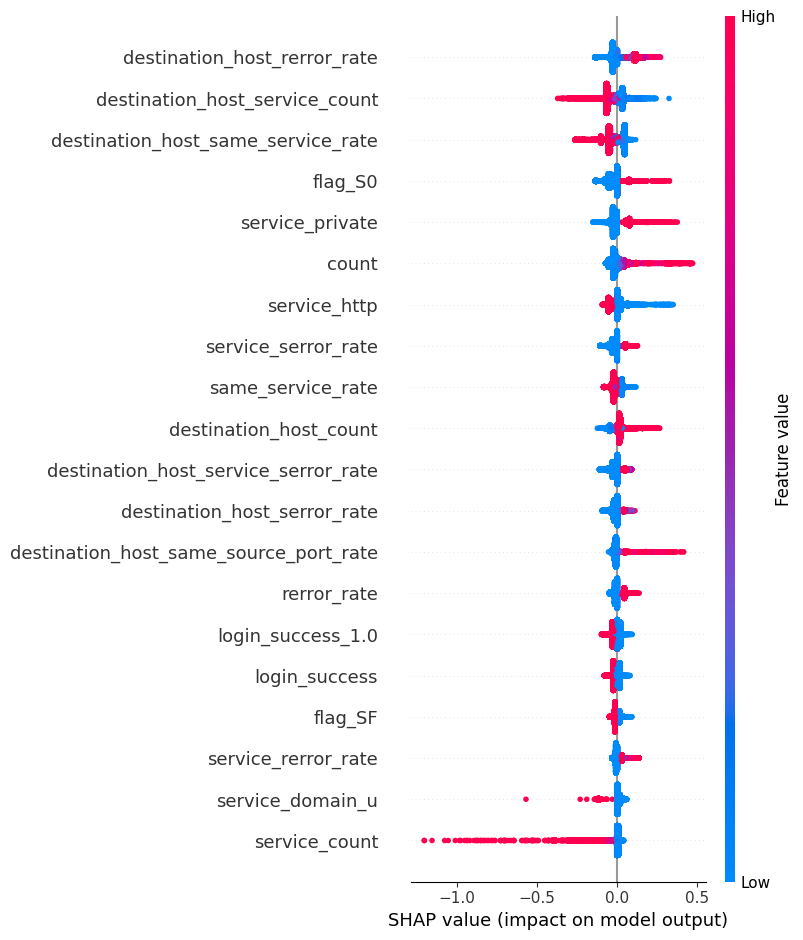

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

X_test_scaled_df.reset_index(drop=True, inplace=True)

# Convert Pandas DataFrame to a NumPy array
X_test_scaled_np = X_test_scaled_df.to_numpy()

# Initialise SHAP's DeepExplainer
explainer = shap.DeepExplainer(dnn_model, X_train_scaled_df[:100].to_numpy())

# Generate SHAP values
shap_values = explainer.shap_values(X_test_scaled_np)

# Remove extra dimention (n_samples, n_features, 1) -> (n_samples, n_features)
shap_values = np.squeeze(shap_values)

# Step 5: SHAP summary plot (this should work fine without JavaScript)
shap.summary_plot(shap_values, X_test_scaled_np, feature_names=X_test_scaled_df.columns)


In [ ]:
DNN - NEW SHAP

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Shape of shap_values: (100, 134)
Shape of X_test_sample_np: (100, 134)


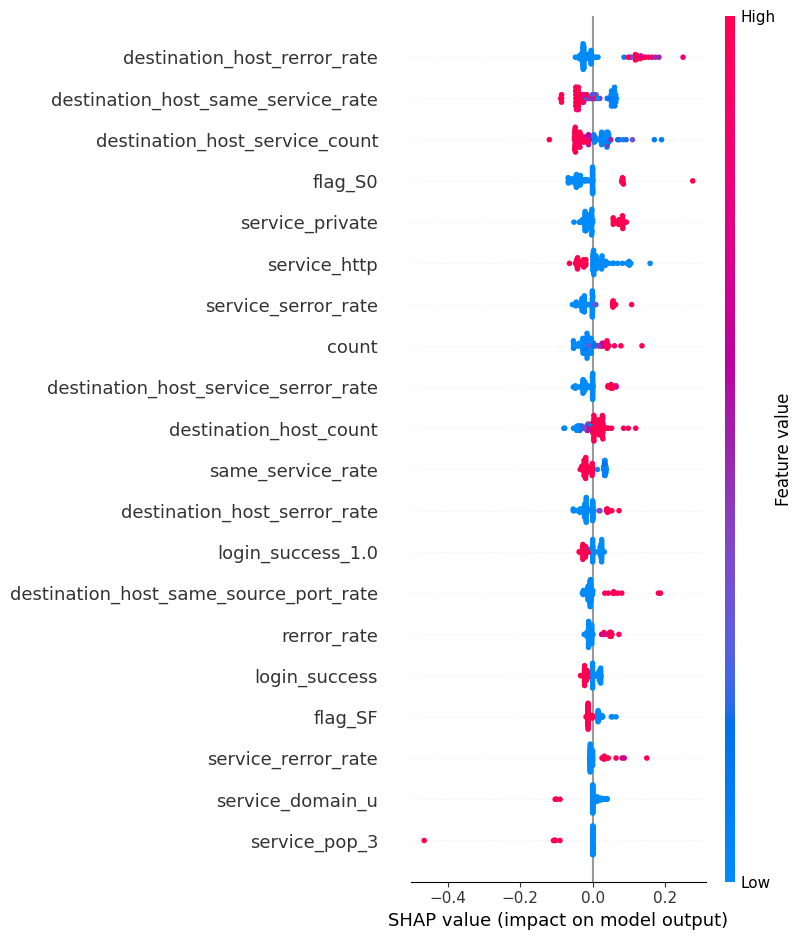

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Randomly select 100 samples from the test set
num_samples = 100
sample_indices = np.random.choice(X_test_scaled_df.index, size=num_samples, replace=False)
X_test_sample = X_test_scaled_df.loc[sample_indices].reset_index(drop=True)

# Convert the sampled DataFrame to a NumPy array
X_test_sample_np = X_test_sample.to_numpy()

# Use a smaller background dataset from the training data (e.g., 50 samples)
background_indices = np.random.choice(X_train_scaled_df.index, size=1000, replace=False)
background = X_train_scaled_df.loc[background_indices].to_numpy()

# Initialize SHAP's DeepExplainer with the background data
explainer = shap.DeepExplainer(dnn_model, background)

# Generate SHAP values for the sampled test data
shap_values = explainer.shap_values(X_test_sample_np)

# If shap_values is a list, extract the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Remove extra dimension if necessary
shap_values = np.squeeze(shap_values)

# Verify that the shapes align
print("Shape of shap_values:", shap_values.shape)
print("Shape of X_test_sample_np:", X_test_sample_np.shape)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test_sample_np, feature_names=X_test_sample.columns)

In [ ]:
Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialise RF
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
rf_model.fit(X_train_scaled_df, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled_df)

# Evaluate model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.97      0.79      9711
           1       0.97      0.62      0.76     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.80      0.77     22544
weighted avg       0.84      0.77      0.77     22544



In [ ]:
RANDOM FOREST LIME

In [ ]:
! pip install lime

import lime
import lime.lime_tabular
import numpy as np

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled_df), # explainer is given Train to understand the distribution of the features, converting to numpy
    feature_names=X_train_scaled_df.columns,
    class_names=['normal', 'attack'], #gives the explainer info if its 0 or 1
    mode='classification' #not a regression task
)

# Pick the instance aka row
i = 2340
instance = X_test_scaled_df.iloc[i].values.reshape(1, -1)

# Generate the explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=rf_model.predict_proba  # Use predict_proba since it's a classification task
)

# Display the explanation
explanation.show_in_notebook(show_table=True, show_all=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
RANDOM FOREST SHAP - corrected

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt


# Initialise the SHAP for RF
explainer = shap.TreeExplainer(rf_model)

# Select subset of the test set (100)
X_test_sample = X_test_scaled_df.iloc[:100].reset_index(drop=True)

# Generate SHAP values
shap_values = explainer.shap_values(X_test_sample)
#print("Shape of shap_values:", shap_values.shape)

# Extract SHAP values for class 1 (positive class)
shap_values_class1 = shap_values[:, :, 1]
#print("Shape of shap_values_class1:", shap_values_class1.shape)

# Ensure the shapes align
#print("Shape of X_test_sample:", X_test_sample.shape)

# Form SHAP summary plot ->  how much each feature contributes to prediction probability for class 1
shap.summary_plot(
    shap_values_class1,
    X_test_sample,
    feature_names=X_test_sample.columns,
    show=False
)
plt.tight_layout()
plt.show()

# # Generate the dependence plot for 'source_bytes'
# feature_name = 'source_bytes'

# if feature_name in X_test_sample.columns:
#     shap.dependence_plot(
#         feature_name,
#         shap_values_class1,
#         X_test_sample,
#         feature_names=X_test_sample.columns,
#         interaction_index=None  # Disable interaction effects
#     )
#     plt.tight_layout()
#     plt.show()
# else:
#     print(f"Feature '{feature_name}' not found in the dataset.")

# # Generate the SHAP force plot for a single instance (optional)
# expected_value_class1 = explainer.expected_value[1]
# single_shap_value = shap_values_class1[0]
# single_instance = X_test_sample.iloc[0]

# shap.force_plot(
#     expected_value_class1,
#     single_shap_value,
#     single_instance,
#     feature_names=X_test_sample.columns,
#     matplotlib=True
# )
# plt.show()


KeyboardInterrupt: 

In [ ]:
Random Forest - SHAP - new

Shape of shap_values: (1000, 134, 2)
Shape of shap_values_class1: (1000, 134)
Shape of X_test_sample: (1000, 134)


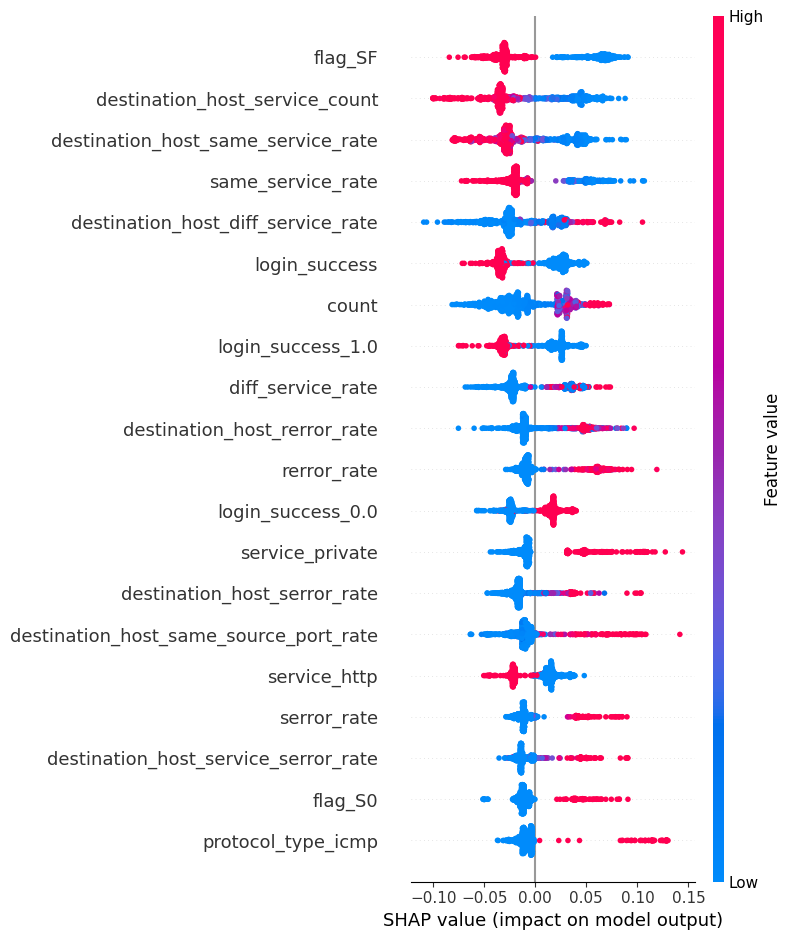

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(rf_model)

# Select a random subset of the test set (100 samples)
X_test_sample = X_test_scaled_df.sample(n=1000, random_state=42).reset_index(drop=True)

# Ensure columns are in the same order as the model's features
# Note: Replace 'feature_names_in_' with 'feature_names' if using an older version of scikit-learn
feature_names_model = rf_model.feature_names_in_
X_test_sample = X_test_sample[feature_names_model]

# Generate SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Determine the structure of shap_values
if isinstance(shap_values, list):
    # shap_values is a list of arrays
    print("shap_values is a list with length:", len(shap_values))
    print("Shape of shap_values[0]:", shap_values[0].shape)
    print("Shape of shap_values[1]:", shap_values[1].shape)

    # Extract SHAP values for class 1
    shap_values_class1 = shap_values[1]
else:
    # shap_values is an array
    print("Shape of shap_values:", shap_values.shape)

    # Extract SHAP values for class 1
    shap_values_class1 = shap_values[:, :, 1]

# Verify shapes
print("Shape of shap_values_class1:", shap_values_class1.shape)
print("Shape of X_test_sample:", X_test_sample.shape)

# Generate SHAP summary plot
shap.summary_plot(
    shap_values_class1,
    X_test_sample,
    feature_names=X_test_sample.columns,
    show=False
)
plt.tight_layout()
plt.show()



In [ ]:
Normal or Attack in RF

In [ ]:
i = 2340
instance = X_test_scaled_df.iloc[i].values.reshape(1, -1)

# Make a prediction for i
predicted_class = rf_model.predict(instance)

class_mapping = {0: 'normal', 1: 'attack'}

actual_class = y_test.iloc[i]

print(f"Instance {i} is predicted as: {class_mapping[predicted_class[0]]}")
print(f"Instance {i} actual label is: {class_mapping[actual_class]}")


Instance 2340 is predicted as: attack
Instance 2340 actual label is: attack


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
Normal or Attack in DNN

In [ ]:
i = 2340
instance = X_test_scaled_df.iloc[i].values.reshape(1, -1)

#predicted_class_prob = dnn_model.predict(instance)

# Convert probabilities to binary class 0 or 1
#predicted_class = (predicted_class_prob > 0.5).astype(int)

class_mapping = {0: 'normal', 1: 'attack'}

actual_class = y_test.iloc[i]

#print(f"Instance {i} is predicted as: {class_mapping[predicted_class[0][0]]}")
print(f"Instance {i} actual label is: {class_mapping[actual_class]}")


Instance 2340 actual label is: attack
